# Exploratory Data Analysis Notebook

In this notebook I explore the dataset I created using data from AlphaVantage. It is always a good idea to have a good sense of what the data are about before doing any modeling. Data explorations allow us to have a sense of the different variables we have at our disposal. It also allows us to know what type of data cleaning we will have to do (getting rid of some rows, inputting some missing values) and get some understanding about how the features interact with each others.

## Libraries

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Data

We can load the dataset we created for ourselves using data from the AlphaVantage API. We will then be able to explore the data to see whether we can find something of value for our upcoming modeling task.

In [47]:
data = pd.read_csv('../data/preprocessed/preprocessed_data_with_target.csv')

## Exploratory Data Analysis

### Basics

Here are some basics information about the dataset

#### Dimensions

In [48]:
print(f"The dataset consists in {len(data)} observations.")

The dataset consists in 3038 observations.


#### Features & Features Types

In [49]:
print(f"The dataset consists in {data.shape[1]} features including the target.")

The dataset consists in 67 features including the target.


In [50]:
print(f"The dataset consists in {data.select_dtypes('number').shape[1]} numerical features")

The dataset consists in 63 numerical features


In [51]:
print(f"The numerical features includes: {data.select_dtypes('number').columns.tolist()[:5]}")

The numerical features includes: ['year', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments']


In [52]:
print(f"Conversely, the dataset consists in {data.select_dtypes('object').shape[1]} non-numerical features")

Conversely, the dataset consists in 4 non-numerical features


In [53]:
print(f"The {data.select_dtypes('object').shape[1]} non-numerical columns are: {data.select_dtypes('object').columns.tolist()}")

The 4 non-numerical columns are: ['symbol', 'fiscalDateEnding', 'Sector', 'Industry']


To sum up, the dataset is comprised of 67 features, 63 of which are numerical. This leaves us with 4 non-numerical features: *symbol*, *fiscalDateEnding*, *Sector*, *Industry*. Among those 4, *symbol* and *fiscalDateEnding* will not be use for modeling but, combined together, as a way to identify each obervation. All in all, we have to deal with only two non-numerical features: *Sector* and *Industry* which both gives us information about the types of companies we are dealing with. We will see later on how we can deal with those variables.

#### Missing Values

**Target variable**

Since we constructed the target variable by shifting the data and merging back, we knew from the beginning that we would have missing values for the target variable. Indeed, we cannot know what would be the target for a 2022 obervation (for instance) as this would be akin to know the EPS in 2027 (using a 5 year shift as we did) which is impossible today (2025).

In [54]:
print(f"There are {int(data['futureEPS'].isna().sum())} missing values in the target variable")

There are 1098 missing values in the target variable


One thing we can do though is making sure that all those missing values are for observations from 2019 onwards.

In [55]:
print(f"Observation years with missing target values: {data[data.futureEPS.isna()]['year'].unique()}")

Observation years with missing target values: [2019 2020 2021 2022 2023 2024 2025]


**Independent variables**

In [56]:
temp = data.copy()
temp.drop(['futureEPS', 'year'], axis=1, inplace=True)
print(f"There are {len(temp.isna().sum()[temp.isna().sum() > 0])} numerical independent variables with missing values")


There are 44 numerical independent variables with missing values


[]

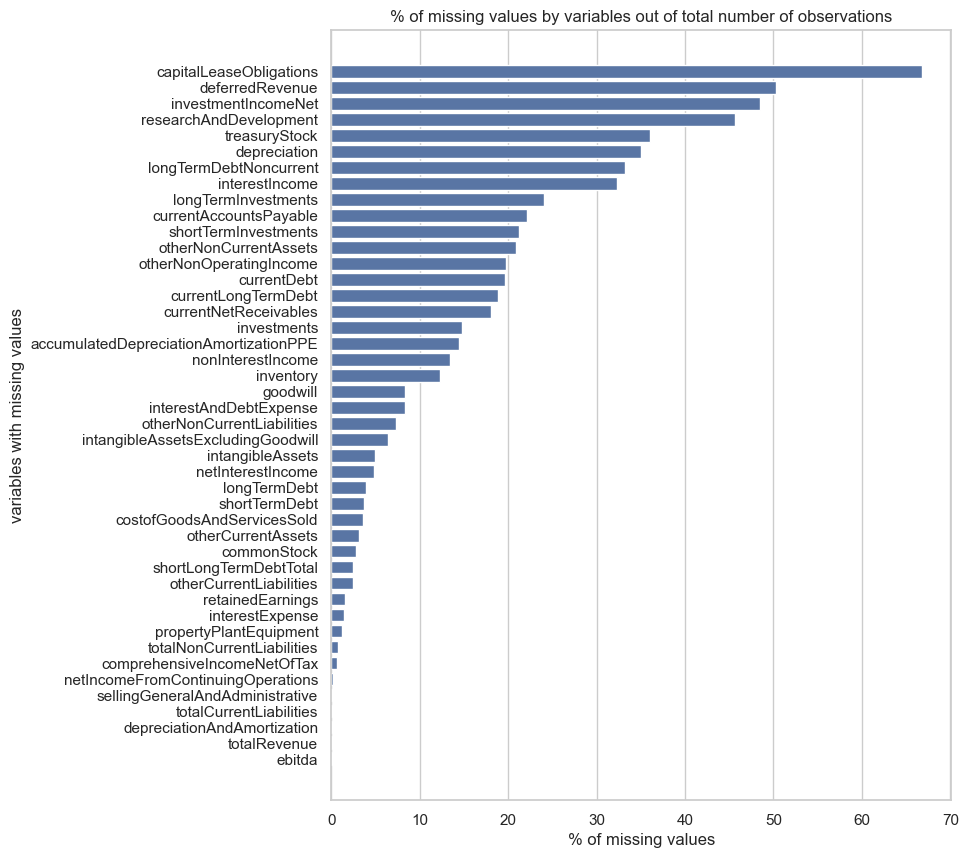

In [57]:
missing_values = round(temp.isna().sum()[temp.isna().sum() > 0] / len(data) * 100, 2).sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.set_theme(style='whitegrid')
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('% of missing values by variables out of total number of observations')
plt.xlabel('% of missing values')
plt.ylabel('variables with missing values')
plt.plot()

This is a lot of missing values! However, I am not too worried about it since those data come from the companies' balance sheets and income statements that they are meant to publish on a regular basis in a very standardized way. I think it is therefore safe to replace those missing values by 0 which means that we consider that some of those companies simply do not have any *capital lease obligations* or *deferred revenue* which seems plausible.

### Correlation Analysis

#### Correlation Matrix

Let's build the correlation matrix with the numerical features. We want to see which features are correlated with the target variable as well as which independent variables are correlated. 

In [58]:
# select numerical features
temp = data.select_dtypes('number')
# remove the year feature
temp.drop('year', axis=1, inplace=True)
# select only observations that have a target and replace missing values across the dataset by 0s
temp = temp[~temp['futureEPS'].isna()].fillna(0)

[]

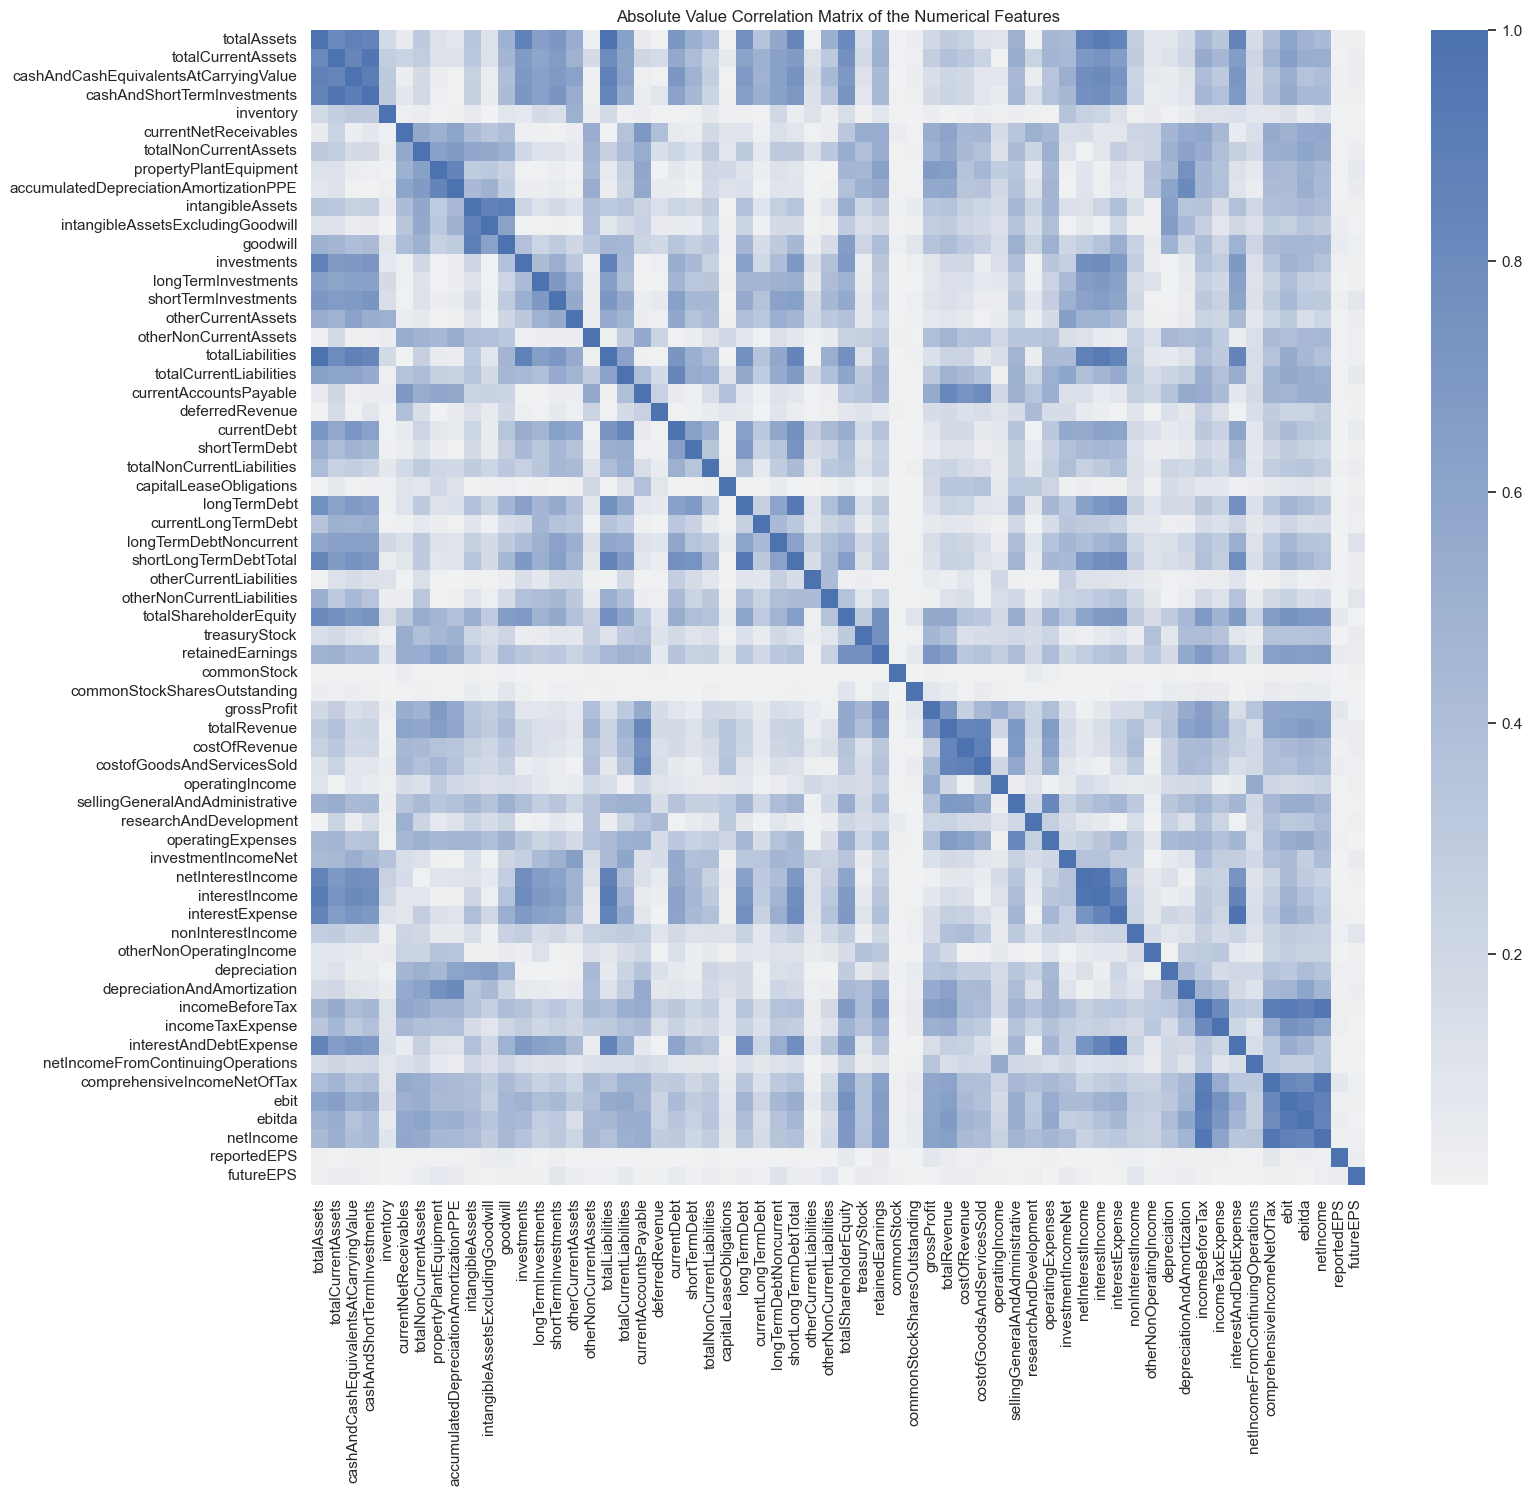

In [59]:
plt.figure(figsize=(17,15))
sns.heatmap(np.abs(temp.corr()), cmap=sns.color_palette("light:b", as_cmap=True))
plt.title("Absolute Value Correlation Matrix of the Numerical Features")
plt.plot()

Some observations we can make from the above heatmap:
- There does not seem to be much correlation between the target (futureEPS) and other variables which is a bit surprising
- There is at least 4 clusters of highly (positively or negatively) correlated variables which means we could probably reduce the number of variables by removing some variables in each of those clusters.

#### Identifying highly correlated variables

Since the number of columns is relatively small, we can iterate through the **correlation matrix** columns and, for each columns, identify all the other variables that have a correlation with that first column greater than our threshold (say 0.8). Since we saw earlier that our target variable is not correlated to any other variable in a meaningful way, it is not worth the effort to keep only the variable with the highest correlation to the target when we deal with a group of highly correlated independent variables.

In [60]:
# creating the correlation matrix (similar to previous block)
temp = data.select_dtypes('number')
temp.drop('year', axis=1, inplace=True)
temp = temp[~temp['futureEPS'].isna()].fillna(0)
temp.drop('futureEPS', axis=1, inplace=True)
corr = temp.corr()

# iterating through the correlation matrix columns and identifying the highly correlated variables
cols_to_remove = []
for col in corr.columns:
    temp_ = corr[col]
    highcorr = temp_[temp_ >= 0.8]
    for elem in highcorr.index:
        # this to make sure we keep one variable among those with high correlation for each column
        if elem != col:
            cols_to_remove.append(elem)
# some variables may have been appended several times so we transform our list into a set
cols_to_remove = set(cols_to_remove)

print(f"We can remove {len(cols_to_remove)} columns from the dataset:")
list(cols_to_remove)
        

We can remove 33 columns from the dataset:


['goodwill',
 'accumulatedDepreciationAmortizationPPE',
 'totalLiabilities',
 'longTermDebt',
 'incomeBeforeTax',
 'cashAndCashEquivalentsAtCarryingValue',
 'operatingExpenses',
 'interestExpense',
 'totalShareholderEquity',
 'totalAssets',
 'totalCurrentLiabilities',
 'costofGoodsAndServicesSold',
 'currentDebt',
 'comprehensiveIncomeNetOfTax',
 'investments',
 'cashAndShortTermInvestments',
 'interestIncome',
 'totalCurrentAssets',
 'ebitda',
 'ebit',
 'totalRevenue',
 'netIncome',
 'depreciationAndAmortization',
 'propertyPlantEquipment',
 'netInterestIncome',
 'intangibleAssets',
 'costOfRevenue',
 'sellingGeneralAndAdministrative',
 'currentAccountsPayable',
 'intangibleAssetsExcludingGoodwill',
 'shortLongTermDebtTotal',
 'incomeTaxExpense',
 'interestAndDebtExpense']

This allowed us to remove 33 columns from our data which is quite substancial. We can now draw a new correlation matrix to see what we are left with:

[]

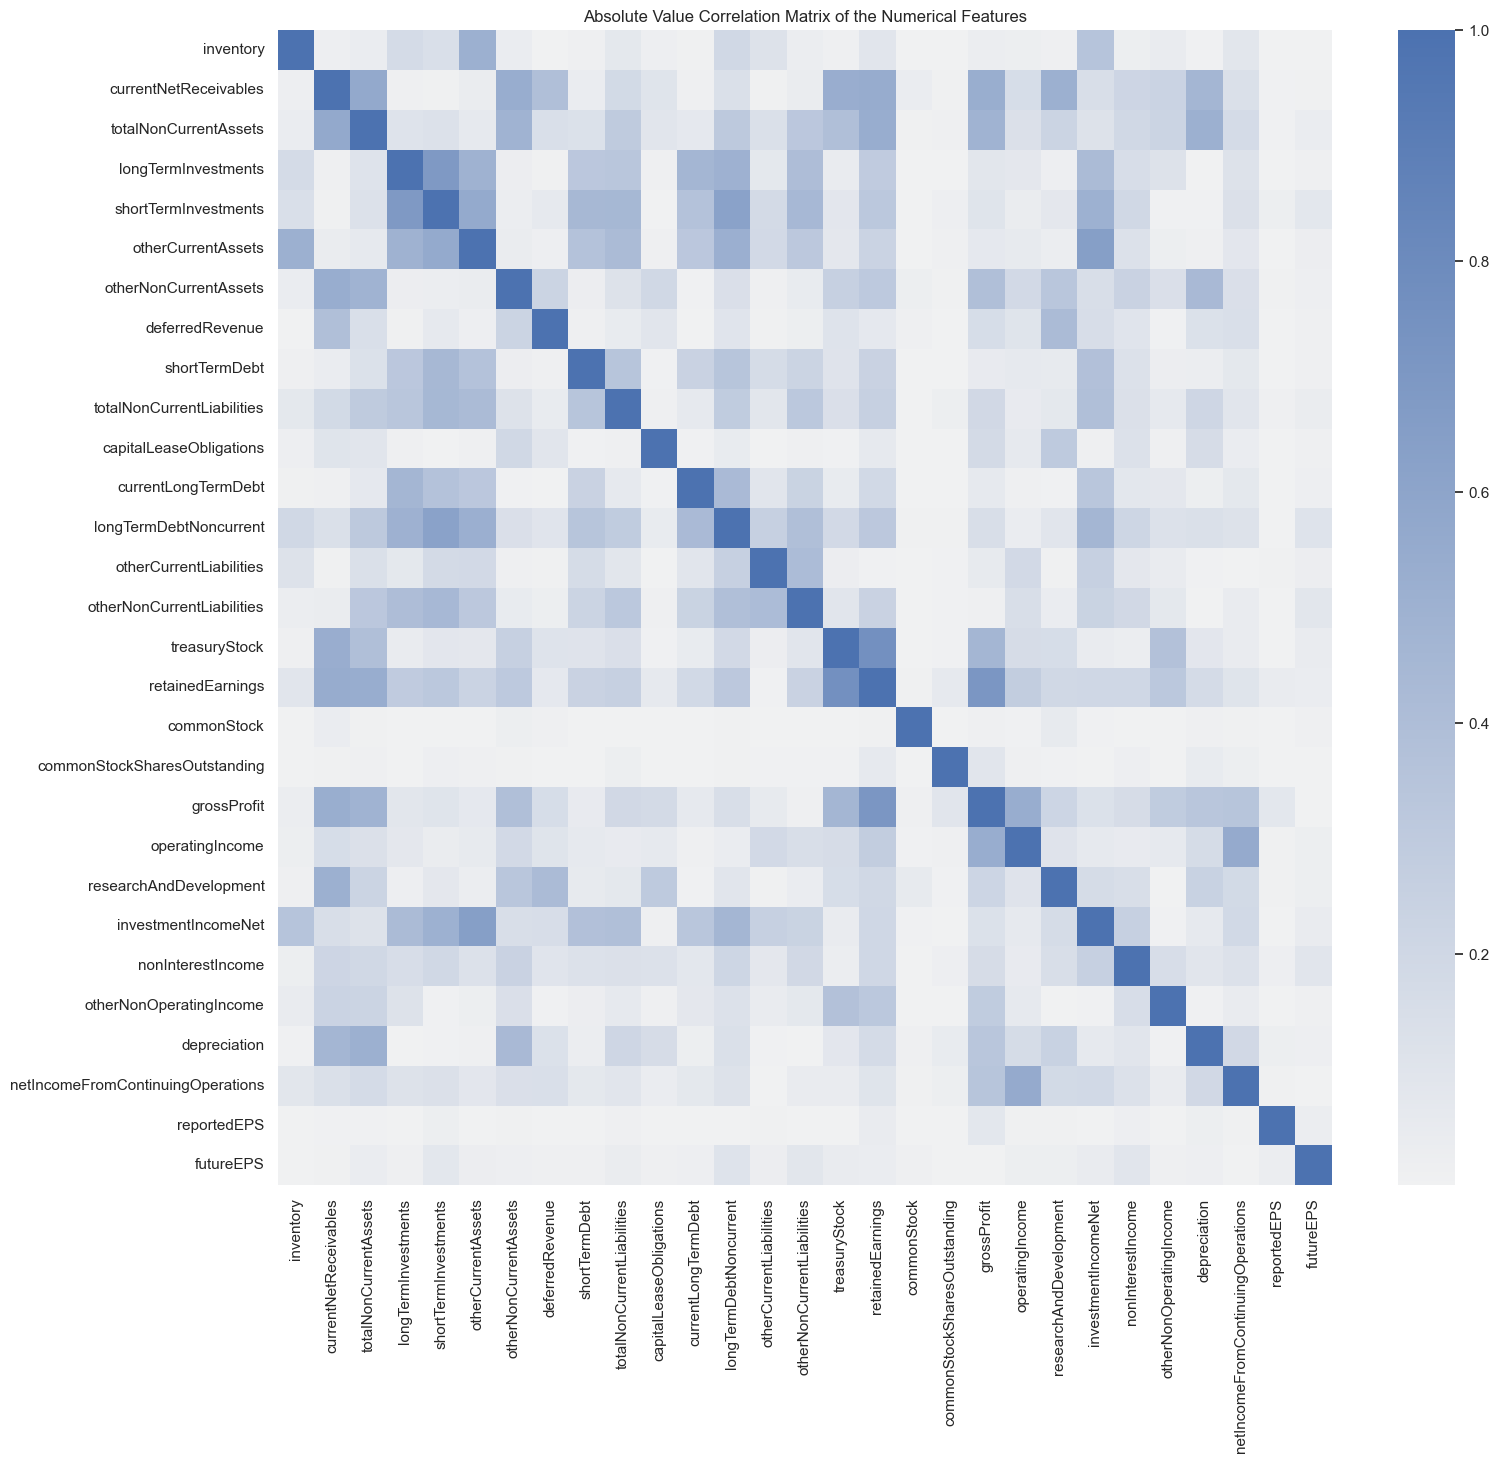

In [61]:
# select numerical features
temp = data.select_dtypes('number')
# remove the year feature
temp.drop('year', axis=1, inplace=True)
temp.drop(cols_to_remove, axis=1, inplace=True)
# select only observations that have a target and replace missing values across the dataset by 0s
temp = temp[~temp['futureEPS'].isna()].fillna(0)
temp.head()

plt.figure(figsize=(17,15))
sns.heatmap(np.abs(temp.corr()), cmap=sns.color_palette("light:b", as_cmap=True))
plt.title("Absolute Value Correlation Matrix of the Numerical Features")
plt.plot()

### Data Distribution

#### Sector

In [62]:
print(f"Only {len(data['Sector'].unique())} different sectors in the dataset")

Only 7 different sectors in the dataset


With only 7 different sectors in the dataset we can probably use one-hot encoding to generate 7 new binary variables without creating a dimensionality problem.

In [63]:
print(f"In our dataset we have the following sectors: {data.Sector.unique()}")

In our dataset we have the following sectors: ['FINANCE' 'TECHNOLOGY' 'LIFE SCIENCES' 'MANUFACTURING'
 'ENERGY & TRANSPORTATION' 'REAL ESTATE & CONSTRUCTION' 'TRADE & SERVICES']


[]

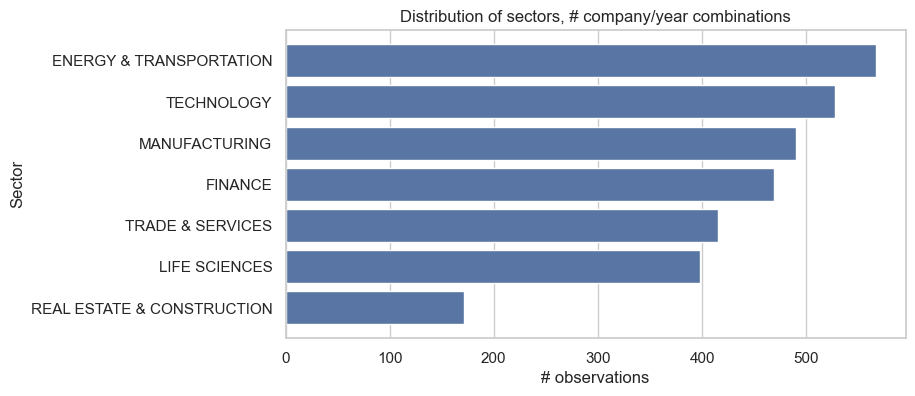

In [64]:
temp = data.Sector.value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=temp.values, y=temp.index)
plt.xlabel('# observations')
plt.title('Distribution of sectors, # company/year combinations')
plt.plot()

#### Industry

In [65]:
print(f"There are {len(data.Industry.unique())} different industries represented in the dataset.")

There are 102 different industries represented in the dataset.


With companies evolving in 102 different industries, it does not look like a good idea at first glance to OHE the industry feature as we may end up with too many features compared to our rather small number of observations.

In [66]:
print(f"A few examples of industries in the dataset: {data.Industry.unique()[:10]}")

A few examples of industries in the dataset: ['SECURITY BROKERS, DEALERS & FLOTATION COMPANIES' 'ELECTRONIC COMPUTERS'
 'PHARMACEUTICAL PREPARATIONS' 'SERVICES-PREPACKAGED SOFTWARE'
 'SEMICONDUCTORS & RELATED DEVICES' 'ELECTRIC SERVICES'
 'ACCIDENT & HEALTH INSURANCE' 'FIRE, MARINE & CASUALTY INSURANCE'
 'BIOLOGICAL PRODUCTS, (NO DISGNOSTIC SUBSTANCES)' 'INVESTMENT ADVICE']


[]

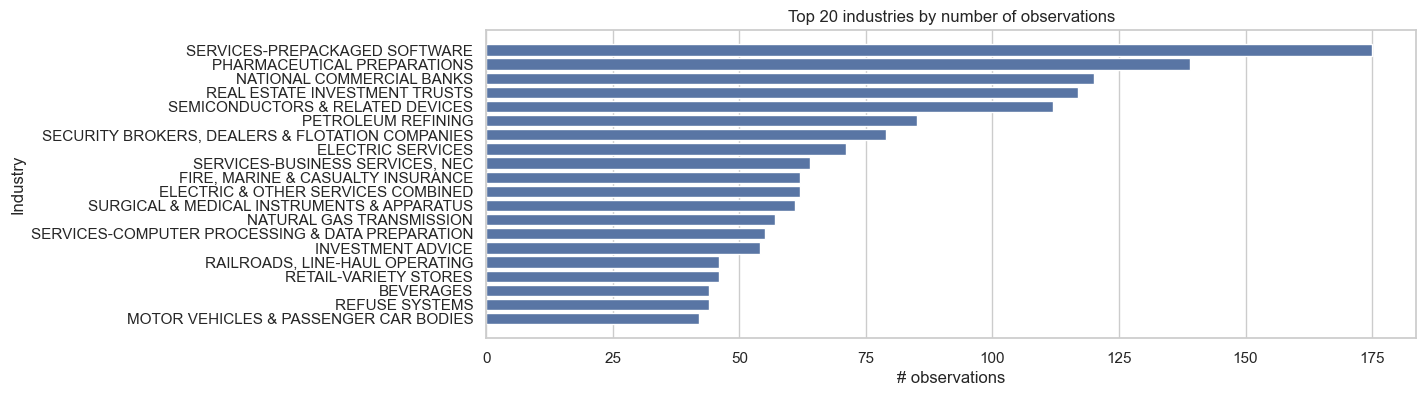

In [67]:
temp = data.Industry.value_counts().head(20)
plt.figure(figsize=(12,4))
sns.barplot(x=temp.values, y=temp.index)
plt.xlabel('# observations')
plt.title('Top 20 industries by number of observations')
plt.plot()

#### Reported EPS and Future EPS

In [68]:
data[['reportedEPS', 'futureEPS']].describe()

,reportedEPS,futureEPS
count,3038.000000,1940.000000
mean,7.014649,6.801162
std,88.789641,9.197665
min,-128.750000,-128.750000
25%,1.910000,2.640000
50%,3.650000,4.720000
75%,6.590000,8.442500
max,4880.000000,153.540000


[]

<Figure size 1200x800 with 0 Axes>

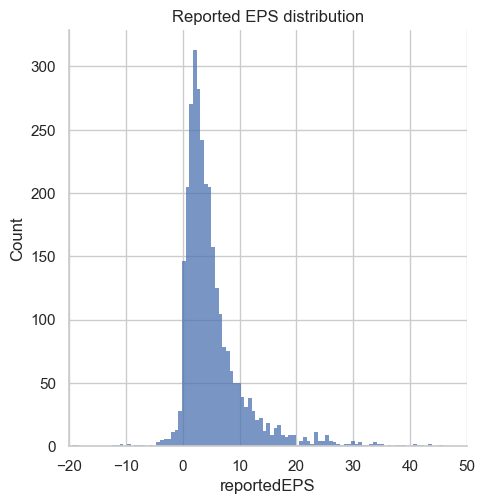

In [69]:
temp = data.copy()
plt.figure(figsize=(12,8))
sns.displot(data=temp, x="reportedEPS")
plt.xlim(-20,50)
plt.title("Reported EPS distribution")
plt.plot()

[]

<Figure size 1200x800 with 0 Axes>

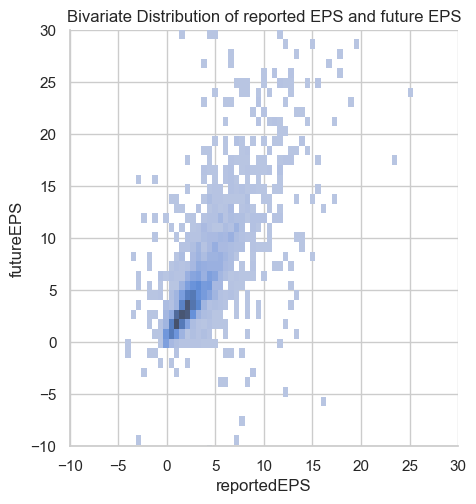

In [70]:
temp = data.copy()
temp = temp[(~temp['futureEPS'].isna())]
plt.figure(figsize=(12,8))
sns.displot(data=temp, x="reportedEPS", y="futureEPS")
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.title("Bivariate Distribution of reported EPS and future EPS")
plt.plot()

The highest density appears to be between 0 and 5$ per share for both the observed EPS and the EPS 5 years later. It is worth zooming in to get a better insight though.

[]

<Figure size 1200x800 with 0 Axes>

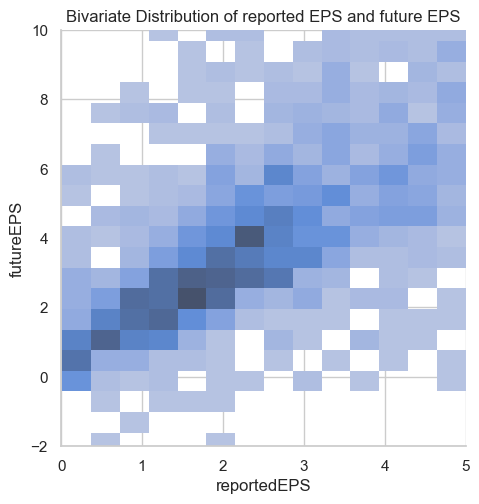

In [71]:
temp = data.copy()
temp = temp[(temp['reportedEPS'] >= 0) & (temp['reportedEPS'] <= 5) & (~temp['futureEPS'].isna())]
plt.figure(figsize=(12,8))
sns.displot(data=temp, x="reportedEPS", y="futureEPS")
plt.xlim(-0,5)
plt.ylim(-2,10)
plt.title("Bivariate Distribution of reported EPS and future EPS")
plt.plot()

Zooming in taught us that the highest density region in the bivariate distribution plot shows an increase in EPS over 5 years.

#### Box-plots

Let's look more in details into a few variables. To do so, we will first change the target variable into a categorical variable. We can consider the following 3 options:
- the EPS significantly increased during the five years
- the EPS decreased during the five years
- the EPS shows no increase or a moderate increase over five years

In [72]:
temp = data.copy()
# we create a new categorical feature that we populate with 'moderate increase'
temp['futureEPSCategory'] = 'moderate increase'
# significant increase (+15% year on average)
mask = temp['futureEPS'] >= temp['reportedEPS'] * 1.15**5
temp.loc[mask, 'futureEPSCategory'] = 'strong increase'
# decrease
mask = temp['futureEPS'] < temp['reportedEPS']
temp.loc[mask, 'futureEPSCategory'] = 'decrease'

In [73]:
# let's quickly check the results
temp[['reportedEPS', 'futureEPS', 'futureEPSCategory']].head(10)

,reportedEPS,futureEPS,futureEPSCategory
0,2.7300,7.0500,strong increase
1,4.0400,10.9400,strong increase
2,5.0900,11.8500,strong increase
3,8.2000,13.6900,moderate increase
4,6.4300,16.6000,strong increase
5,0.2225,1.6075,strong increase
6,3.7200,2.2800,decrease
7,1.5400,1.3100,decrease
8,0.9700,2.4000,strong increase
9,3.0000,3.4400,moderate increase


It seems it works as intended. Not we can build a few box-plots with regards to that new variable to see if we can find something useful. To keep it short we will only look at the 5 variables that show a slightly higher correlation to the target than the other ones: shortTermInvestments, longTermDebtNoncurrent, otherNonCurrentLiabilities, nonInterestIncome.

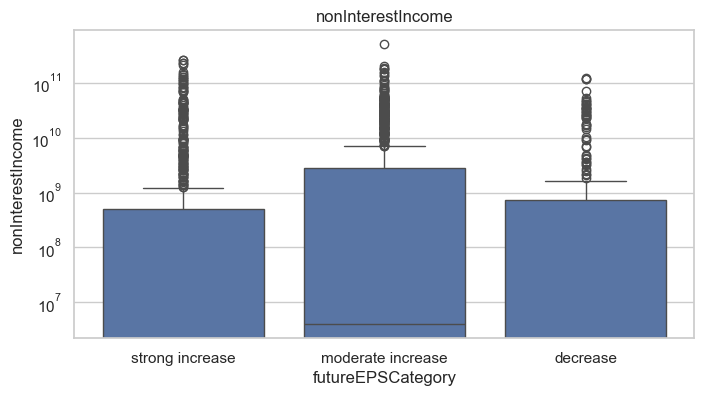

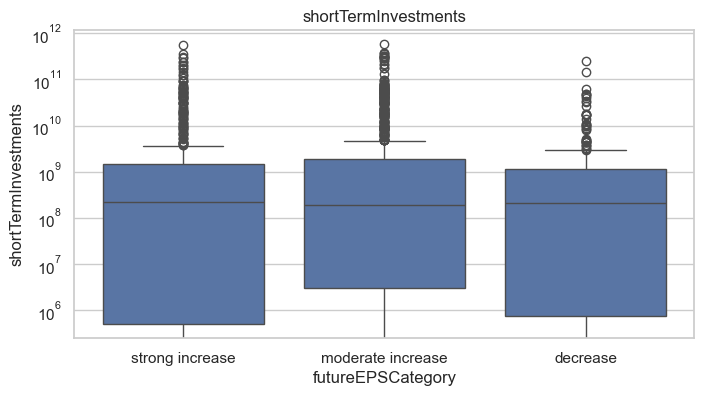

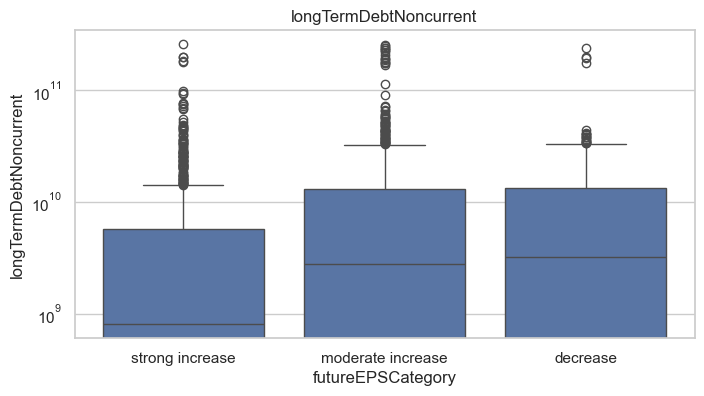

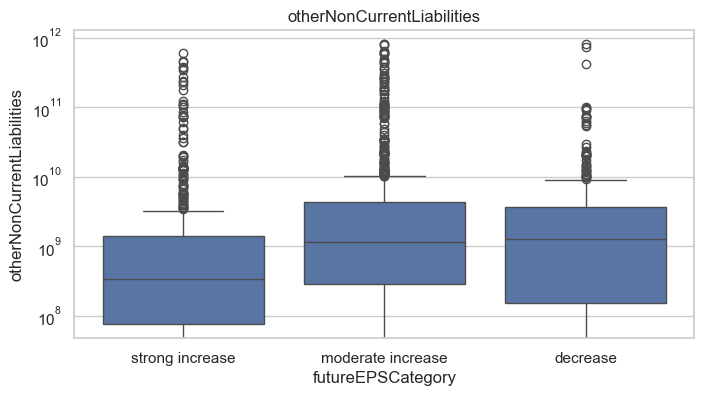

In [74]:
cols = ['nonInterestIncome', 'shortTermInvestments', 'longTermDebtNoncurrent', 'otherNonCurrentLiabilities']
temp = temp[~temp['futureEPS'].isna()].fillna(0)

for c in cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=temp, x='futureEPSCategory', y=c)
    plt.title(c)
    plt.yscale('log')
    plt.plot()

From the above plots, we can infer that:
- otherNonCurrentLiabilitiles and longTermDebtNoncurrent seem to provide a way to seperate the observations that showed a substantial increase from the other two categories.
- the other two variables we looked at do not provide much guidance

## Insights gained

This is a relatively short and basic Exploratory Data Analysis (EDA) but still, we managed to get some insights about our dataset. The new information we gathered will be very helpful in determining how we clean our dataset and can also give us some guidance about how to model. Here is a summary of what we learned.

### Dataset shape

- Small dataset with ~3k observations
- 67 features including the target, 63 of which are numerical
- 2 non-numerical features to ID each observation
- 2 non-numerical features to define the sector and industry the company is evolving in. We may need to OHE them which would results in many more features.

### Missing values

- 1099 missing values for the target variable which was expected
- 2018 Cisco issue due to exact data merging between balance sheet data and income statement data. This lead to missing target value in 2013. Code must be fixed by merging on YYYY-MM instead.
- independent variable missing values to be replaced by 0

### Categorical variables

- Only 7 different sectors in the dataset, OHE should not lead to a dimensionality issue
- 102 different industries represented so it might not be wise to OHE this feature. We could though OHE the top ones and create an "other" categories for the others

### Distribution

- The maximum reportedEPS value is 4880 which is an outlier and something we need to keep in mind should we use a model that is sensitive to outliers
- in terms of EPS distribution highest density region is between 0$ and 5$ per share for both the observed and future EPS. Zooming in reveals that even in this high density region EPS increased over the 5 years.

### Correlation analysis

- There is not much correlation between the target and other variables which is a bit surprising.
- However, we have some clusters of highly correlated variables which means we could reduce the dataset dimensions by removing some of them in each cluster. This is going to be helpful especially if we then add more variables by one-hot encoding the sector and/or industry features.
- We could remove 33 highly correlated numerical variables from the dataset

### Independent variable relations with target variable

- debt and liability related variables seem important in determining whether EPS will show a strong growth


### Conclusion

We managed to get some interesting and useful information from EDA. Once again, much more could be done here, we only scratched the surface to keep it relatively short. That said, if modeling does not go as intended we may have to come back and further explore the data later on.
